# Reduced Likelihood for Linear Regression

This notebook demonstrates CoFI's `ReducedLikelihood` class for handling unknown data covariance in inverse problems.

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_reduced_likelihood.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

## Problem Setup

We fit a polynomial curve to noisy data:
$$y(x) = \sum_{n=0}^N m_n x^n$$

The true model is: $y = -6 - 5x + 2x^2 + x^3$

In matrix form, the forward problem is $\mathbf{d} = \mathbf{G}\mathbf{m}$, where $\mathbf{G}$ is the Vandermonde matrix.

---
## 1. Import Modules

In [85]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.utils import QuadraticReg, ReducedLikelihood

np.random.seed(42)

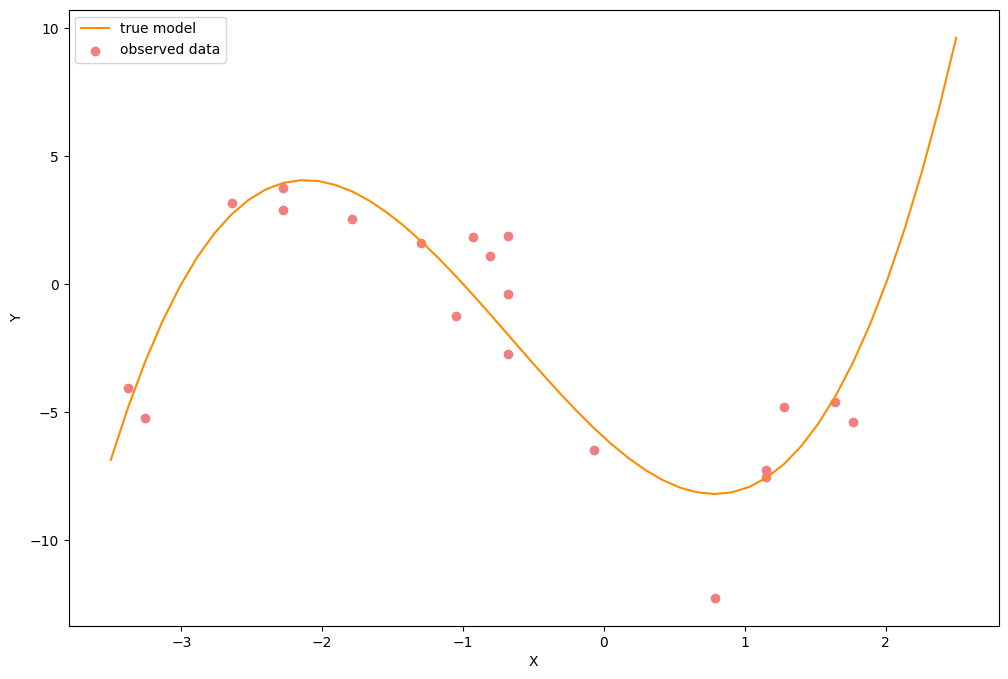

In [87]:
# generate data with random Gaussian noise
def basis_func(x):
    return np.array([x**i for i in range(4)]).T                           # x -> G
_m_true = np.array([-6,-5,2,1])                                           # m
sample_size = 20                                                        # N
sigma = 2.0                                                             # noise standard deviation
x = np.random.choice(np.linspace(-3.5,2.5), size=sample_size)             # x
def forward_func(m):
    return basis_func(x) @ m                                              # m -> y_synthetic
y_observed = forward_func(_m_true) + np.random.normal(0, sigma, sample_size)  # d
y_observed_std = np.std(y_observed)

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.scatter(x, y_observed, color="lightcoral", label="observed data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

---
## 3. Reduced Likelihood Theory

In many inverse problems, the data covariance $C_d$ is unknown and must be estimated alongside the model parameters. The **reduced likelihood** approach marginalizes over the unknown covariance parameters.

### Standard Gaussian Likelihood

The standard log-likelihood for Gaussian errors is:

$$\log p(\mathbf{d}|\mathbf{m}, C_d) = -\frac{1}{2}\mathbf{r}^T C_d^{-1} \mathbf{r} - \frac{1}{2}\log|C_d| - \frac{n}{2}\log(2\pi)$$

where $\mathbf{r} = \mathbf{d} - \mathbf{G}\mathbf{m}$ is the residual vector.

### Reduced Likelihood Cases

CoFI's `ReducedLikelihood` class supports five cases for estimating $C_d$:

| Case | Covariance Model | Parameters Estimated | Degrees of Freedom |
|------|------------------|---------------------|-------------------|
| `'none'` | $C_d$ fixed (known) | 0 | - |
| `'scaled'` | $C_d = a \cdot C_{d,ref}$ | 1 (scale factor $a$) | Well-posed |
| `'spherical'` | $C_d = s \cdot I$ | 1 (variance $s$) | Well-posed |
| `'diag'` | $C_d = \text{diag}(\sigma_1^2, \ldots, \sigma_n^2)$ | $n$ (one per data point) | Ill-posed |
| `'full'` | $C_d = \mathbf{r}\mathbf{r}^T$ | Outer product | Rank-1 approximation |

### Maximum Likelihood Estimates

For each case, the ML estimate of the covariance is:

- **'scaled'**: $\hat{a} = \frac{1}{n}\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}$
- **'spherical'**: $\hat{s} = \frac{1}{n}\|\mathbf{r}\|^2$
- **'diag'**: $\hat{\sigma}_i^2 = r_i^2$
- **'full'**: $\hat{C}_d = \mathbf{r}\mathbf{r}^T$

### Marginalized reduced likelihood estimates

To handle the instability of the `diag_legacy` case, a marginalized reduced likelihood implementation is also available. The marginalization of the Gaussian likelihood standard deviations $\sigma_i^2 i=\{1,...,n\}$ is done with priors $\sigma_i^2 \sim IG(\frac{\nu}{2},\frac{{\nu}s^2}{2})$. The exact C_d is not available in this case and its effective components are estimmated as: $\sigma^2_{i,\textrm{eff}}=\frac{{\nu}s^2+r_{i}^2}{\nu+1}$ where $r_i$ is the residual assocaited with the $i^{\textrm{th}}$ data point. 

In [88]:
# Define known covariance matrices for testing
# These are the "true" covariance matrices we'll use to assess each case

# Cases 1-3 use the original data (y_observed) with simple Gaussian noise
# Case 1: 'none' - We know the exact covariance (sigma^2 * I)
Cd_true_none = np.eye(sample_size) * (sigma**2)

# Case 2: 'scaled' - We have a reference covariance (identity) that will be scaled
Cd_ref_scaled = np.eye(sample_size)
# The true covariance is actually sigma^2 * I, so scale factor should be sigma^2

# Case 3: 'spherical' - True covariance is sigma^2 * I (spherical with s = sigma^2)
Cd_true_spherical = np.eye(sample_size) * (sigma**2)

# Cases 4-5: Generate NEW datasets with specific covariance structures
# Case 4: 'diag' - Create a diagonal covariance with varying variances
np.random.seed(42)
diag_variances = np.random.uniform(0.5, 1.5, sample_size)
Cd_true_diag = np.diag(diag_variances)

# Generate data with diagonal covariance (independent but different variances)
noise_diag = np.random.randn(sample_size) * np.sqrt(diag_variances)
y_observed_diag = forward_func(_m_true) + noise_diag

# Case 5: 'full' - Create a full covariance matrix
A = np.random.randn(sample_size, sample_size)
Cd_true_full = A @ A.T / sample_size + 0.1 * np.eye(sample_size)  # Ensure positive definite

# Generate data with full covariance (correlated noise)
noise_full = np.random.multivariate_normal(np.zeros(sample_size), Cd_true_full)
y_observed_full = forward_func(_m_true) + noise_full

print(f"True covariance matrices and datasets defined:")
print(f"  - none:      Uses y_observed, Cd shape {Cd_true_none.shape}, variance {sigma**2}")
print(f"  - scaled:    Uses y_observed, Cd_ref shape {Cd_ref_scaled.shape}")
print(f"  - spherical: Uses y_observed, Cd shape {Cd_true_spherical.shape}, variance {sigma**2}")
print(f"  - diag:      Uses y_observed_diag, Cd shape {Cd_true_diag.shape}, varying variances")
print(f"               Variance range: [{diag_variances.min():.3f}, {diag_variances.max():.3f}]")
print(f"  - full:      Uses y_observed_full, Cd shape {Cd_true_full.shape}, full covariance")
print(f"               Condition number: {np.linalg.cond(Cd_true_full):.2f}")

True covariance matrices and datasets defined:
  - none:      Uses y_observed, Cd shape (20, 20), variance 4.0
  - scaled:    Uses y_observed, Cd_ref shape (20, 20)
  - spherical: Uses y_observed, Cd shape (20, 20), variance 4.0
  - diag:      Uses y_observed_diag, Cd shape (20, 20), varying variances
               Variance range: [0.521, 1.470]
  - full:      Uses y_observed_full, Cd shape (20, 20), full covariance
               Condition number: 31.36


In [89]:
print(np.linalg.matrix_rank(A))

20


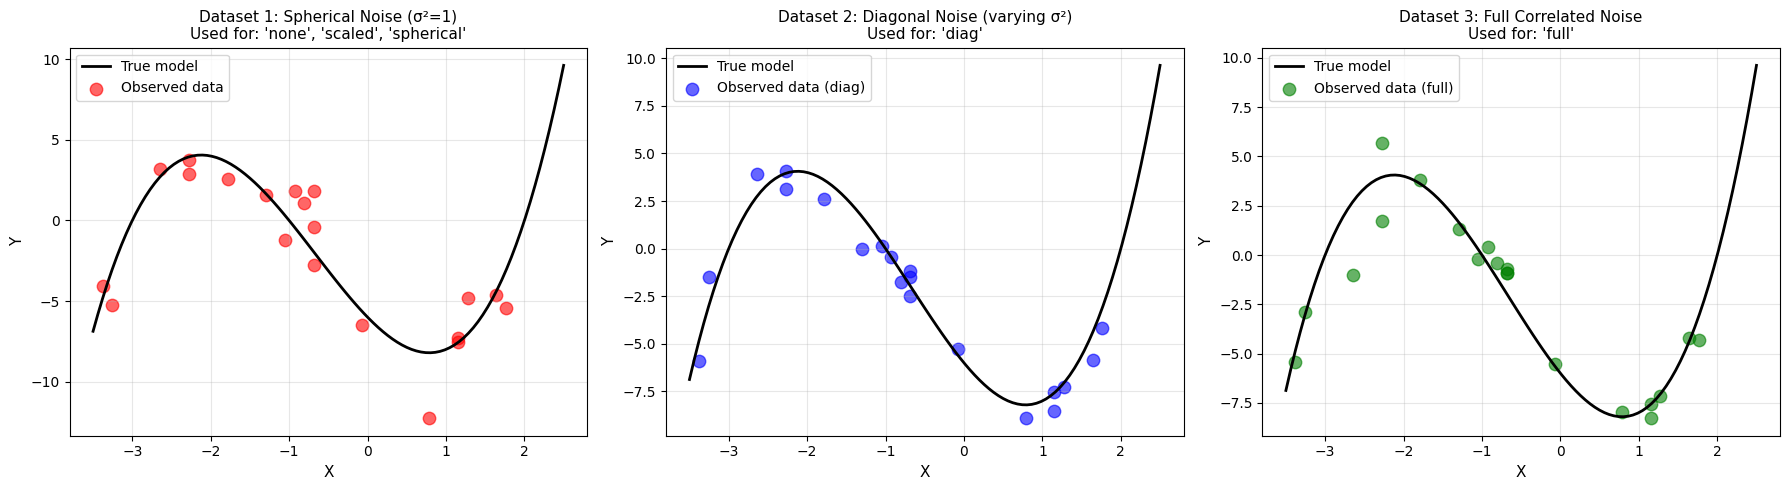

In [90]:
# Visualize the three different datasets
_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dataset 1: Original (cases none, scaled, spherical)
axes[0].plot(_x_plot, _y_plot, 'k-', linewidth=2, label='True model')
axes[0].scatter(x, y_observed, color='red', s=80, alpha=0.6, label='Observed data')
axes[0].set_xlabel('X', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title("Dataset 1: Spherical Noise (σ²=1)\nUsed for: 'none', 'scaled', 'spherical'", fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Dataset 2: Diagonal covariance (case diag)
axes[1].plot(_x_plot, _y_plot, 'k-', linewidth=2, label='True model')
axes[1].scatter(x, y_observed_diag, color='blue', s=80, alpha=0.6, label='Observed data (diag)')
axes[1].set_xlabel('X', fontsize=11)
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title("Dataset 2: Diagonal Noise (varying σ²)\nUsed for: 'diag'", fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Dataset 3: Full covariance (case full)
axes[2].plot(_x_plot, _y_plot, 'k-', linewidth=2, label='True model')
axes[2].scatter(x, y_observed_full, color='green', s=80, alpha=0.6, label='Observed data (full)')
axes[2].set_xlabel('X', fontsize=11)
axes[2].set_ylabel('Y', fontsize=11)
axes[2].set_title("Dataset 3: Full Correlated Noise\nUsed for: 'full'", fontsize=11)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Case 1: `'none'` - Fixed Known Covariance

When the data covariance is known exactly, we use the standard Gaussian likelihood:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{1}{2}\mathbf{r}^T C_d^{-1} \mathbf{r} + \text{const}$$

**Gradient:** $\nabla_\mathbf{m} \log p = \mathbf{G}^T C_d^{-1} \mathbf{r}$

**Hessian:** $\mathbf{H} = -\mathbf{G}^T C_d^{-1} \mathbf{G}$

In [91]:
# Create ReducedLikelihood with case='none'
lik_none = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    Cd_ref=Cd_true_none,
    case='none'
)

# Define inverse problem
inv_problem_rl_none = BaseProblem()
inv_problem_rl_none.name = "Polynomial Regression - ReducedLikelihood (none)"
inv_problem_rl_none.set_objective(lambda m: -lik_none.log_likelihood(m))
inv_problem_rl_none.set_gradient(lambda m: -lik_none.gradient(m))
inv_problem_rl_none.set_hessian(lambda m: -lik_none.hessian(m))
inv_problem_rl_none.set_initial_model(np.zeros(4))

# Set up inversion
inv_options_rl_none = InversionOptions()
inv_options_rl_none.set_tool("scipy.optimize.minimize")
inv_options_rl_none.set_params(method="Newton-CG")

# Run inversion
inv_rl_none = Inversion(inv_problem_rl_none, inv_options_rl_none)
result_rl_none = inv_rl_none.run()

print(f"Success: {result_rl_none.success}")
print(f"Estimated model: {result_rl_none.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_none.model - _m_true):.6f}")

# Verify the ML covariance equals the input covariance
Cd_ml_none = lik_none.get_ml_cov(result_rl_none.model)
print(f"\nCovariance check:")
print(f"  ML covariance matches input: {np.allclose(Cd_ml_none, Cd_true_none)}")

Success: True
Estimated model: [-5.43928719 -5.21807615  1.65107323  0.94944749]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.697325

Covariance check:
  ML covariance matches input: True


### Case 2: `'scaled'` - Scaled Reference Covariance

The covariance is a scaled version of a known reference: $C_d = a \cdot C_{d,ref}$

The reduced log-likelihood (after marginalizing over $a$) is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{n}{2}\log\left(\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}\right) + \text{const}$$

The ML estimate of the scale factor is: $\hat{a} = \frac{1}{n}\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}$

In [92]:
# Create ReducedLikelihood with case='scaled'
lik_scaled = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    Cd_ref=Cd_ref_scaled,
    case='scaled'
)

# Define inverse problem
inv_problem_rl_scaled = BaseProblem()
inv_problem_rl_scaled.set_objective(lambda m: -lik_scaled.log_likelihood(m))
inv_problem_rl_scaled.set_gradient(lambda m: -lik_scaled.gradient(m))
inv_problem_rl_scaled.set_hessian(lambda m: -lik_scaled.hessian(m))
inv_problem_rl_scaled.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_scaled = InversionOptions()
inv_options_rl_scaled.set_tool("scipy.optimize.minimize")
inv_options_rl_scaled.set_params(method="Newton-CG")

inv_rl_scaled = Inversion(inv_problem_rl_scaled, inv_options_rl_scaled)
result_rl_scaled = inv_rl_scaled.run()

print(f"Success: {result_rl_scaled.success}")
print(f"Estimated model: {result_rl_scaled.model}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_scaled.model - _m_true):.6f}")

# Get estimated covariance and check the scale factor
Cd_ml_scaled = lik_scaled.get_ml_cov(result_rl_scaled.model)
estimated_scale = Cd_ml_scaled[0, 0]
true_scale = sigma**2
print(f"\nEstimated scale factor: {estimated_scale:.4f}")
print(f"True scale factor:      {true_scale:.4f}")
print(f"Scale factor error:     {abs(estimated_scale - true_scale):.4f}")

Success: True
Estimated model: [-5.43928719 -5.21807615  1.65107323  0.94944749]
Error (L2 norm): 0.697325

Estimated scale factor: 2.9923
True scale factor:      4.0000
Scale factor error:     1.0077


### Case 3: `'spherical'` - Spherical Covariance

The covariance is isotropic: $C_d = s \cdot I$ (same variance for all data points)

The reduced log-likelihood is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{n}{2}\log\left(\|\mathbf{r}\|^2\right) + \text{const}$$

The ML estimate of the variance is: $\hat{s} = \frac{1}{n}\|\mathbf{r}\|^2$

This is the most common case when noise statistics are unknown but assumed to be uniform.

In [93]:
# Create ReducedLikelihood with case='spherical'
lik_spherical = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    case='spherical'
)

# Define inverse problem
inv_problem_rl_spherical = BaseProblem()
inv_problem_rl_spherical.set_objective(lambda m: -lik_spherical.log_likelihood(m))
inv_problem_rl_spherical.set_gradient(lambda m: -lik_spherical.gradient(m))
inv_problem_rl_spherical.set_hessian(lambda m: -lik_spherical.hessian(m))
inv_problem_rl_spherical.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_spherical = InversionOptions()
inv_options_rl_spherical.set_tool("scipy.optimize.minimize")
inv_options_rl_spherical.set_params(method="Newton-CG")

inv_rl_spherical = Inversion(inv_problem_rl_spherical, inv_options_rl_spherical)
result_rl_spherical = inv_rl_spherical.run()

print(f"Success: {result_rl_spherical.success}")
print(f"Estimated model: {result_rl_spherical.model}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_spherical.model - _m_true):.6f}")

# Get estimated covariance and compare to true spherical covariance
Cd_ml_spherical = lik_spherical.get_ml_cov(result_rl_spherical.model)
estimated_variance = Cd_ml_spherical[0, 0]
true_variance = sigma**2
print(f"\nEstimated variance: {estimated_variance:.4f}")
print(f"True variance:      {true_variance:.4f}")
print(f"Variance error:     {abs(estimated_variance - true_variance):.4f}")
print(f"Covariance is spherical: {np.allclose(np.diag(Cd_ml_spherical), Cd_ml_spherical[0, 0] * np.ones(sample_size))}")

Success: True
Estimated model: [-5.43928719 -5.21807615  1.65107323  0.94944749]
Error (L2 norm): 0.697325

Estimated variance: 2.9923
True variance:      4.0000
Variance error:     1.0077
Covariance is spherical: True


### Case 4: `'diag'` - Diagonal Covariance

Each data point has its own variance: $C_d = \text{diag}(\sigma_1^2, \ldots, \sigma_n^2)$

The reduced log-likelihood is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\sum_{i=1}^{n} \log|r_i| + \text{const}$$

The ML estimates are: $\hat{\sigma}_i^2 = r_i^2$

**Warning:** This case is **ill-posed** because we estimate $n$ variance parameters from $n$ data points. The Hessian becomes singular when residuals approach zero. Strong regularization is required for stable inversion.

In [94]:
# Create ReducedLikelihood with case='diag'
# Uses y_observed_diag (data with diagonal covariance)
lik_diag = ReducedLikelihood(
    data=y_observed_diag,
    forward_func=forward_func,
    G=basis_func(x),
    case='diag'
)

# Create regularization with damping
#n_dims = 4
#my_reg = QuadraticReg(
#    weighting_matrix='damping',
#    model_shape=(n_dims,)
#)

# Define inverse problem WITH REGULARIZATION
# Manually combine likelihood and regularization in each function
inv_problem_rl_diag = BaseProblem()
#inv_problem_rl_diag.set_objective(lambda m: -lik_diag.log_likelihood(m) + my_reg(m))
#inv_problem_rl_diag.set_gradient(lambda m: -lik_diag.gradient(m) + my_reg.gradient(m))
#inv_problem_rl_diag.set_hessian(lambda m: -lik_diag.hessian(m) + my_reg.hessian(m))
inv_problem_rl_diag.set_objective(lambda m: -lik_diag.log_likelihood(m)) 
inv_problem_rl_diag.set_gradient(lambda m: -lik_diag.gradient(m)) 
inv_problem_rl_diag.set_hessian(lambda m: -lik_diag.hessian(m)) 
inv_problem_rl_diag.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_diag = InversionOptions()
inv_options_rl_diag.set_tool("scipy.optimize.minimize")
inv_options_rl_diag.set_params(method="Newton-CG")

inv_rl_diag = Inversion(inv_problem_rl_diag, inv_options_rl_diag)
result_rl_diag = inv_rl_diag.run()

print(f"Success: {result_rl_diag.success}")
print(f"Estimated model: {result_rl_diag.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_diag.model - _m_true):.6f}")

# Compare estimated vs true diagonal covariance
Cd_ml_diag = lik_diag.get_ml_cov(result_rl_diag.model)
estimated_diag_vars = np.diag(Cd_ml_diag)
true_diag_vars = np.diag(Cd_true_diag)

print(f"\nDiagonal variance comparison (first 5 elements):")
print(f"  Estimated: {estimated_diag_vars[:5]}")
print(f"  True:      {true_diag_vars[:5]}")
print(f"  Mean abs error: {np.mean(np.abs(estimated_diag_vars - true_diag_vars)):.4f}")

Success: True
Estimated model: [-5.99872519 -4.94096831  1.72901476  0.89553595]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.296365

Diagonal variance comparison (first 5 elements):
  Estimated: [0.84921755 0.82930462 0.88050711 0.82949233 1.14124695]
  True:      [0.87454012 1.45071431 1.23199394 1.09865848 0.65601864]
  Mean abs error: 0.2748


### Case 4b: `'diag_legacy'` - Legacy Diagonal Covariance

**WARNING:** This case is **deprecated** and included only for backward compatibility.

The legacy diagonal case uses a different formulation:

$$\log p(\mathbf{d}|\mathbf{m}) = -\sum_{i=1}^{n} \log|r_i| + \text{const}$$

where $r_i$ is the residual for data point $i$.

**Problems with this formulation:**
- Weights are proportional to $1/r_i$, which blow up near zero residuals
- Numerically unstable when residuals approach zero
- The gradient $\nabla_m \log p = G^T (1/r)$ becomes singular

**Use `'diag'` instead**, which implements a Student-t likelihood that is robust to outliers and numerically stable.

In [95]:
# Create ReducedLikelihood with case='diag_legacy'
# Uses y_observed_diag (data with diagonal covariance) - same as 'diag' case
lik_diag_legacy = ReducedLikelihood(
    data=y_observed_diag,
    forward_func=forward_func,
    G=basis_func(x),
    case='diag_legacy'
)

# Define inverse problem WITHOUT REGULARIZATION (same setup as 'diag' case)
inv_problem_rl_diag_legacy = BaseProblem()
inv_problem_rl_diag_legacy.set_objective(lambda m: -lik_diag_legacy.log_likelihood(m)) 
inv_problem_rl_diag_legacy.set_gradient(lambda m: -lik_diag_legacy.gradient(m)) 
inv_problem_rl_diag_legacy.set_hessian(lambda m: -lik_diag_legacy.hessian(m)) 
inv_problem_rl_diag_legacy.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_diag_legacy = InversionOptions()
inv_options_rl_diag_legacy.set_tool("scipy.optimize.minimize")
inv_options_rl_diag_legacy.set_params(method="Newton-CG")

inv_rl_diag_legacy = Inversion(inv_problem_rl_diag_legacy, inv_options_rl_diag_legacy)
result_rl_diag_legacy = inv_rl_diag_legacy.run()

print(f"Success: {result_rl_diag_legacy.success}")
print(f"Estimated model: {result_rl_diag_legacy.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_diag_legacy.model - _m_true):.6f}")

# Compare estimated vs true diagonal covariance
Cd_ml_diag_legacy = lik_diag_legacy.get_ml_cov(result_rl_diag_legacy.model)
estimated_diag_vars_legacy = np.diag(Cd_ml_diag_legacy)
true_diag_vars = np.diag(Cd_true_diag)

print(f"\nDiagonal variance comparison (first 5 elements):")
print(f"  Estimated (legacy): {estimated_diag_vars_legacy[:5]}")
print(f"  Estimated (diag):   {estimated_diag_vars[:5]}")
print(f"  True:               {true_diag_vars[:5]}")
print(f"  Mean abs error (legacy): {np.mean(np.abs(estimated_diag_vars_legacy - true_diag_vars)):.4f}")
print(f"  Mean abs error (diag):   {np.mean(np.abs(estimated_diag_vars - true_diag_vars)):.4f}")

# Compare with 'diag' case
print(f"\nComparison with 'diag' case:")
print(f"  Model difference (L2): {np.linalg.norm(result_rl_diag_legacy.model - result_rl_diag.model):.6f}")

Success: False
Estimated model: [0. 0. 0. 0.]
True model:      [-6 -5  2  1]
Error (L2 norm): 8.124038

Diagonal variance comparison (first 5 elements):
  Estimated (legacy): [72.59586547 27.60998464  6.78090518 34.37033371 15.29769866]
  Estimated (diag):   [0.84921755 0.82930462 0.88050711 0.82949233 1.14124695]
  True:               [0.87454012 1.45071431 1.23199394 1.09865848 0.65601864]
  Mean abs error (legacy): 21.2815
  Mean abs error (diag):   0.2748

Comparison with 'diag' case:
  Model difference (L2): 8.011826


### Case 5: `'full'` - Full Covariance Matrix

The full covariance matrix is estimated as the outer product of residuals:

$$\hat{C}_d = \mathbf{r}\mathbf{r}^T$$

The reduced log-likelihood is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{n}{2}\log\left(\|\mathbf{r}\|^2\right) + \text{const}$$

Note: This produces a rank-1 covariance estimate. For a single realization, this is mathematically equivalent to the 'spherical' case for the model estimate, but the estimated covariance structure differs.

In [96]:
# Create ReducedLikelihood with case='full'
# Uses y_observed_full (data with full correlated covariance)
lik_full = ReducedLikelihood(
    data=y_observed_full,
    forward_func=forward_func,
    G=basis_func(x),
    case='full'
)

# Note: ReducedLikelihood does NOT have a reg parameter - you must manually combine
# likelihood and regularization in the objective, gradient, and hessian functions
inv_problem_rl_full = BaseProblem()

# Combine likelihood + regularization: objective = -log_likelihood + regularization
inv_problem_rl_full.set_objective(lambda m: -lik_full.log_likelihood(m))
inv_problem_rl_full.set_gradient(lambda m: -lik_full.gradient(m)) 
inv_problem_rl_full.set_hessian(lambda m: -lik_full.hessian(m))
inv_problem_rl_full.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_full = InversionOptions()
inv_options_rl_full.set_tool("scipy.optimize.minimize")
inv_options_rl_full.set_params(method="Newton-CG")

inv_rl_full = Inversion(inv_problem_rl_full, inv_options_rl_full)
result_rl_full = inv_rl_full.run()

print(f"Success: {result_rl_full.success}")
print(f"Estimated model: {result_rl_full.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_full.model - _m_true):.6f}")

# Compare estimated vs true full covariance
Cd_ml_full = lik_full.get_ml_cov(result_rl_full.model)
frob_error_full = np.linalg.norm(Cd_ml_full - Cd_true_full, 'fro')
rel_error_full = frob_error_full / np.linalg.norm(Cd_true_full, 'fro')

print(f"\nFull covariance comparison:")
print(f"  Frobenius norm error: {frob_error_full:.4f}")
print(f"  Relative error:       {rel_error_full:.4f}")
print(f"  Is symmetric:         {np.allclose(Cd_ml_full, Cd_ml_full.T)}")

Success: True
Estimated model: [-5.16332608 -4.84881026  1.4916057   0.87871705]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.998026

Full covariance comparison:
  Frobenius norm error: 21.2529
  Relative error:       3.4479
  Is symmetric:         True


#### Comparison of ReducedLikelihood Cases by Dataset

Since each covariance case uses a different dataset (with different noise structures), we compare results separately for each dataset group:

- **Dataset 1** (`y_observed`): Spherical noise with $\sigma^2 = 4$ — used by `'none'`, `'scaled'`, `'spherical'`
- **Dataset 2** (`y_observed_diag`): Diagonal noise with varying variances — used by `'diag'`, `'diag_legacy'`
- **Dataset 3** (`y_observed_full`): Full correlated noise — used by `'full'`

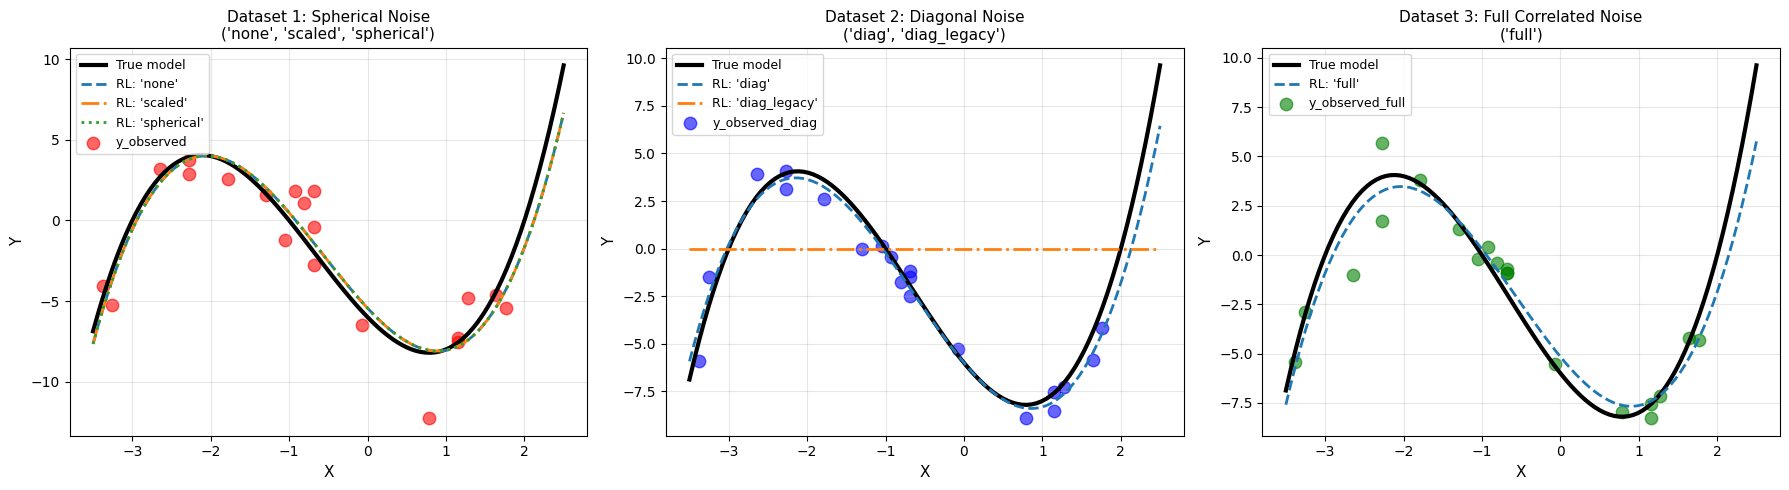

In [101]:
# Plot fitted curves separately for each dataset
_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dataset 1: y_observed (none, scaled, spherical)
axes[0].plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=3, label='True model')
axes[0].plot(_x_plot, _G_plot @ result_rl_none.model, '--', linewidth=2, label="RL: 'none'")
axes[0].plot(_x_plot, _G_plot @ result_rl_scaled.model, '-.', linewidth=2, label="RL: 'scaled'")
axes[0].plot(_x_plot, _G_plot @ result_rl_spherical.model, ':', linewidth=2, label="RL: 'spherical'")
axes[0].scatter(x, y_observed, color='red', s=80, alpha=0.6, label='y_observed')
axes[0].set_xlabel('X', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title("Dataset 1: Spherical Noise\n('none', 'scaled', 'spherical')", fontsize=11)
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# Dataset 2: y_observed_diag (diag, diag_legacy)
axes[1].plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=3, label='True model')
axes[1].plot(_x_plot, _G_plot @ result_rl_diag.model, '--', linewidth=2, label="RL: 'diag'")
axes[1].plot(_x_plot, _G_plot @ result_rl_diag_legacy.model, '-.', linewidth=2, label="RL: 'diag_legacy'")
axes[1].scatter(x, y_observed_diag, color='blue', s=80, alpha=0.6, label='y_observed_diag')
axes[1].set_xlabel('X', fontsize=11)
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title("Dataset 2: Diagonal Noise\n('diag', 'diag_legacy')", fontsize=11)
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

# Dataset 3: y_observed_full (full)
axes[2].plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=3, label='True model')
axes[2].plot(_x_plot, _G_plot @ result_rl_full.model, '--', linewidth=2, label="RL: 'full'")
axes[2].scatter(x, y_observed_full, color='green', s=80, alpha=0.6, label='y_observed_full')
axes[2].set_xlabel('X', fontsize=11)
axes[2].set_ylabel('Y', fontsize=11)
axes[2].set_title("Dataset 3: Full Correlated Noise\n('full')", fontsize=11)
axes[2].legend(fontsize=9)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [102]:
# Create comparison tables separated by dataset

print("=" * 70)
print("Dataset 1: y_observed (Spherical Noise, σ² = 4)")
print("=" * 70)
results_dict_1 = {
    'Case': ['True', "'none'", "'scaled'", "'spherical'"],
    'm0': [_m_true[0], result_rl_none.model[0], result_rl_scaled.model[0], result_rl_spherical.model[0]],
    'm1': [_m_true[1], result_rl_none.model[1], result_rl_scaled.model[1], result_rl_spherical.model[1]],
    'm2': [_m_true[2], result_rl_none.model[2], result_rl_scaled.model[2], result_rl_spherical.model[2]],
    'm3': [_m_true[3], result_rl_none.model[3], result_rl_scaled.model[3], result_rl_spherical.model[3]],
    'Error': [0.0, 
              np.linalg.norm(result_rl_none.model - _m_true),
              np.linalg.norm(result_rl_scaled.model - _m_true),
              np.linalg.norm(result_rl_spherical.model - _m_true)],
}
df1 = pd.DataFrame(results_dict_1)
print(df1.to_string(index=False))

print("\n" + "=" * 70)
print("Dataset 2: y_observed_diag (Diagonal Noise, varying variances)")
print("=" * 70)
results_dict_2 = {
    'Case': ['True', "'diag'", "'diag_legacy'"],
    'm0': [_m_true[0], result_rl_diag.model[0], result_rl_diag_legacy.model[0]],
    'm1': [_m_true[1], result_rl_diag.model[1], result_rl_diag_legacy.model[1]],
    'm2': [_m_true[2], result_rl_diag.model[2], result_rl_diag_legacy.model[2]],
    'm3': [_m_true[3], result_rl_diag.model[3], result_rl_diag_legacy.model[3]],
    'Error': [0.0,
              np.linalg.norm(result_rl_diag.model - _m_true),
              np.linalg.norm(result_rl_diag_legacy.model - _m_true)],
}
df2 = pd.DataFrame(results_dict_2)
print(df2.to_string(index=False))

print("\n" + "=" * 70)
print("Dataset 3: y_observed_full (Full Correlated Noise)")
print("=" * 70)
results_dict_3 = {
    'Case': ['True', "'full'"],
    'm0': [_m_true[0], result_rl_full.model[0]],
    'm1': [_m_true[1], result_rl_full.model[1]],
    'm2': [_m_true[2], result_rl_full.model[2]],
    'm3': [_m_true[3], result_rl_full.model[3]],
    'Error': [0.0, np.linalg.norm(result_rl_full.model - _m_true)],
}
df3 = pd.DataFrame(results_dict_3)
print(df3.to_string(index=False))

print("\n" + "=" * 70)
print("Note: Results across datasets are NOT directly comparable since")
print("each dataset has different noise realizations.")
print("=" * 70)

Dataset 1: y_observed (Spherical Noise, σ² = 4)
       Case        m0        m1       m2       m3    Error
       True -6.000000 -5.000000 2.000000 1.000000 0.000000
     'none' -5.439287 -5.218076 1.651073 0.949447 0.697325
   'scaled' -5.439287 -5.218076 1.651073 0.949447 0.697325
'spherical' -5.439287 -5.218076 1.651073 0.949447 0.697325

Dataset 2: y_observed_diag (Diagonal Noise, varying variances)
         Case        m0        m1       m2       m3    Error
         True -6.000000 -5.000000 2.000000 1.000000 0.000000
       'diag' -5.998725 -4.940968 1.729015 0.895536 0.296365
'diag_legacy'  0.000000  0.000000 0.000000 0.000000 8.124038

Dataset 3: y_observed_full (Full Correlated Noise)
  Case        m0       m1       m2       m3    Error
  True -6.000000 -5.00000 2.000000 1.000000 0.000000
'full' -5.163326 -4.84881 1.491606 0.878717 0.998026

Note: Results across datasets are NOT directly comparable since
each dataset has different noise realizations.


#### Visualize Estimated Covariance Matrices

Let's examine the estimated data covariance matrices for each case. Note that each case uses a dataset with noise drawn from a specific covariance structure, and we compare the estimated covariance to the true covariance used to generate that dataset.

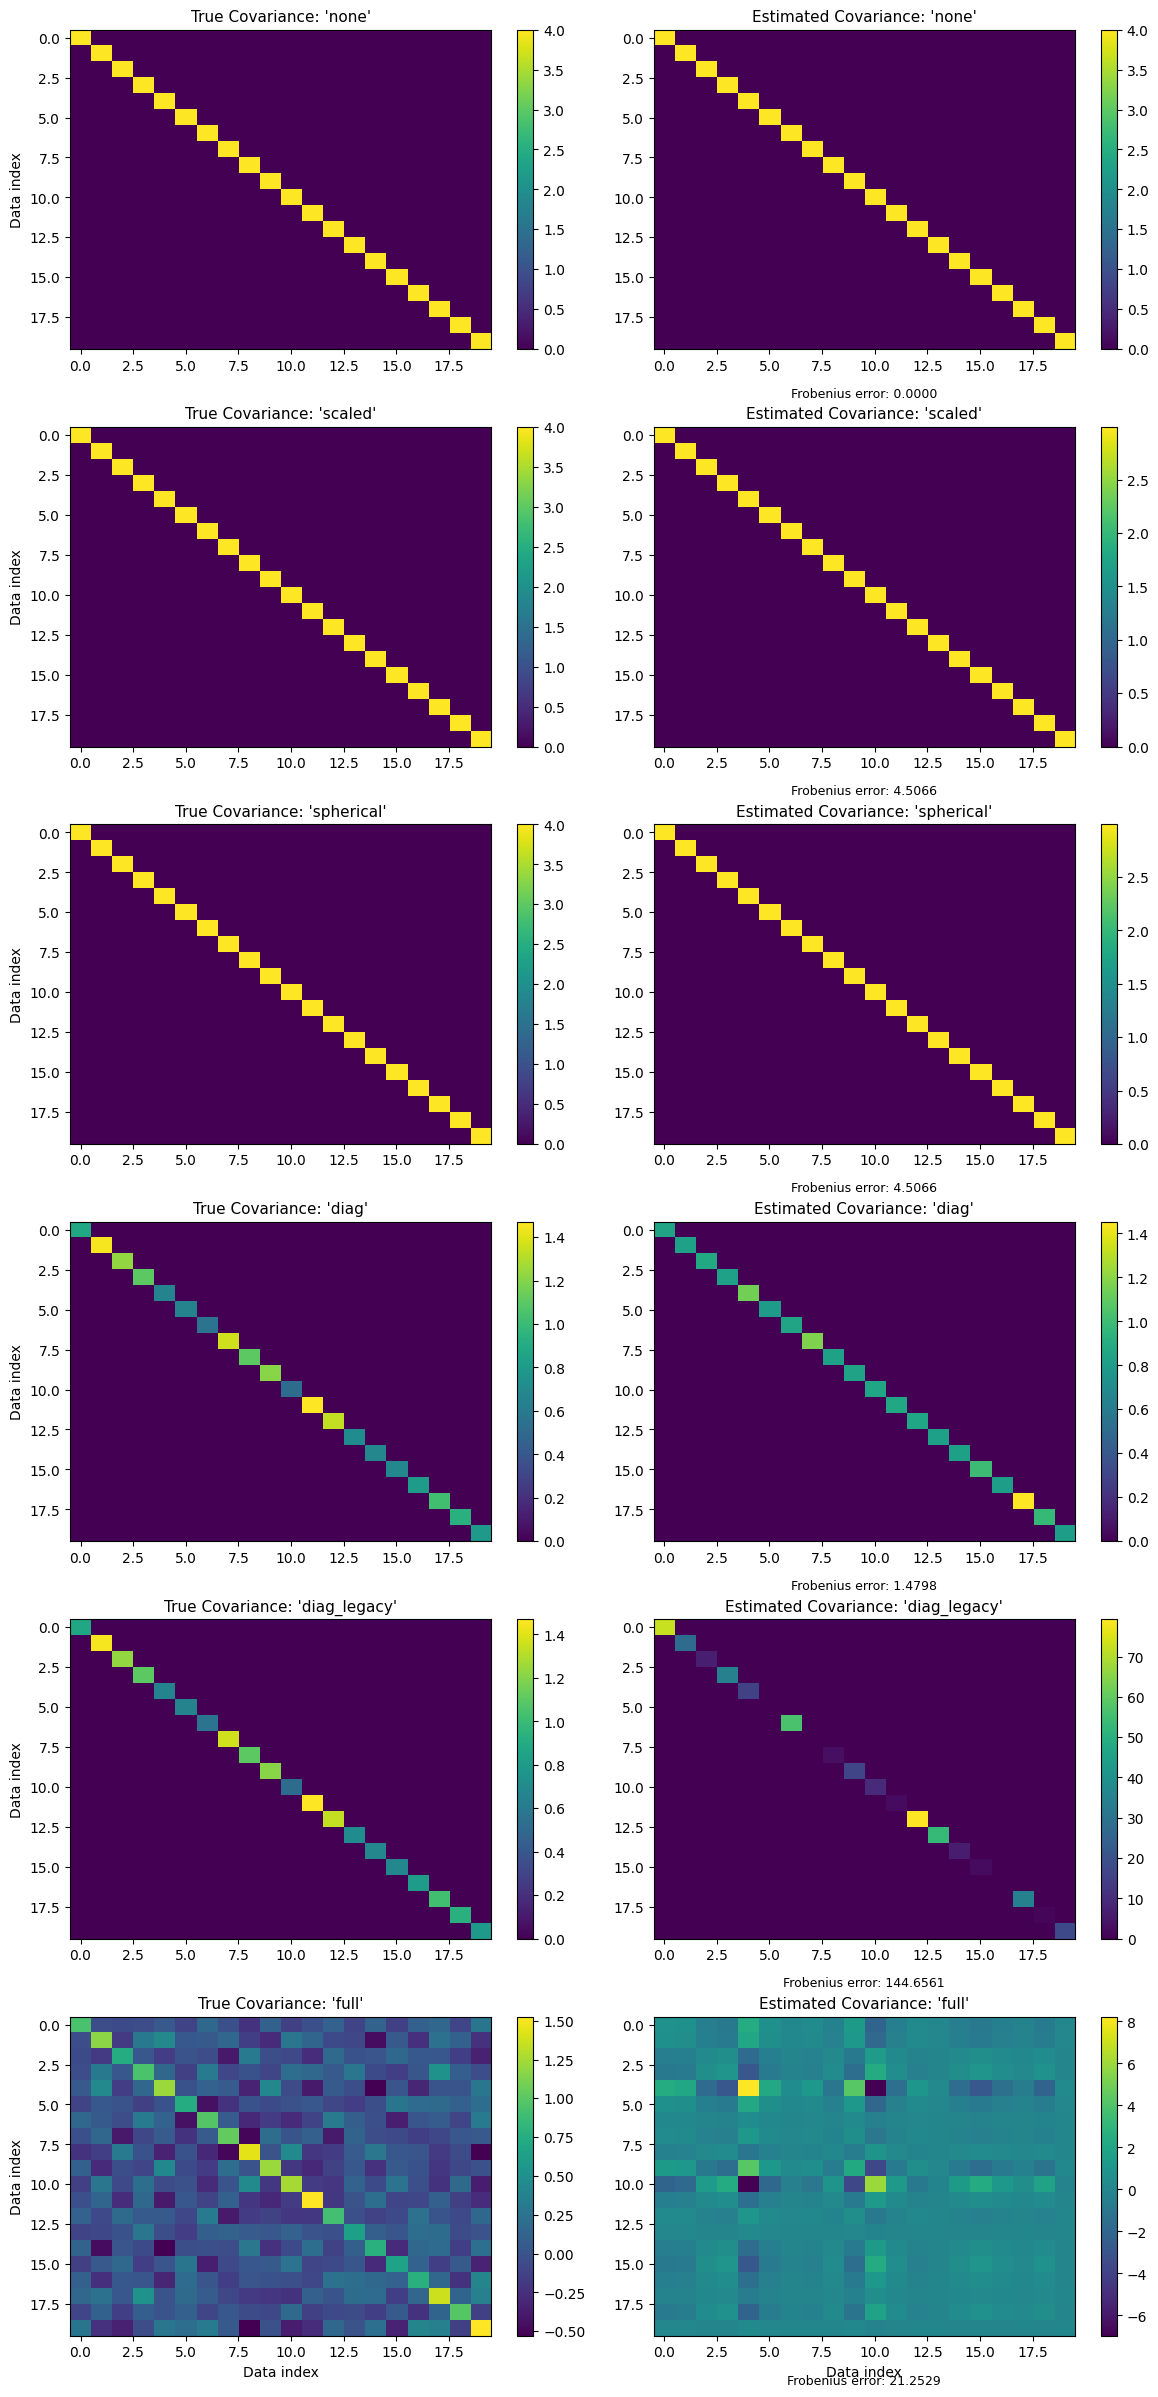


Covariance Matrix Comparison:
Case 'none':
  Frobenius norm error: 0.000000
  Relative error:       0.000000

Case 'scaled':
  Frobenius norm error: 4.506564
  Relative error:       0.251925

Case 'spherical':
  Frobenius norm error: 4.506564
  Relative error:       0.251925

Case 'diag':
  Frobenius norm error: 1.479772
  Relative error:       0.329714

Case 'diag_legacy':
  Frobenius norm error: 144.656107
  Relative error:       32.231367

Case 'full':
  Frobenius norm error: 21.252857
  Relative error:       3.447852



In [103]:
# Get all estimated covariances
Cd_ml_none = lik_none.get_ml_cov(result_rl_none.model)
Cd_ml_scaled = lik_scaled.get_ml_cov(result_rl_scaled.model)
Cd_ml_spherical = lik_spherical.get_ml_cov(result_rl_spherical.model)
Cd_ml_diag = lik_diag.get_ml_cov(result_rl_diag.model)
Cd_ml_diag_legacy = lik_diag_legacy.get_ml_cov(result_rl_diag_legacy.model)
Cd_ml_full = lik_full.get_ml_cov(result_rl_full.model)

# Plot comparison: True vs Estimated covariance matrices
fig, axes = plt.subplots(6, 2, figsize=(12, 24))

covariances = [
    ('none', Cd_true_none, Cd_ml_none),
    ('scaled', Cd_true_spherical, Cd_ml_scaled),  # True is spherical
    ('spherical', Cd_true_spherical, Cd_ml_spherical),
    ('diag', Cd_true_diag, Cd_ml_diag),
    ('diag_legacy', Cd_true_diag, Cd_ml_diag_legacy),
    ('full', Cd_true_full, Cd_ml_full),
]

for idx, (case_name, Cd_true, Cd_ml) in enumerate(covariances):
    # True covariance
    im0 = axes[idx, 0].imshow(Cd_true, cmap='viridis', aspect='auto')
    axes[idx, 0].set_title(f"True Covariance: '{case_name}'", fontsize=11)
    axes[idx, 0].set_ylabel("Data index")
    if idx == 5:
        axes[idx, 0].set_xlabel("Data index")
    plt.colorbar(im0, ax=axes[idx, 0])
    
    # Estimated covariance
    im1 = axes[idx, 1].imshow(Cd_ml, cmap='viridis', aspect='auto')
    axes[idx, 1].set_title(f"Estimated Covariance: '{case_name}'", fontsize=11)
    if idx == 5:
        axes[idx, 1].set_xlabel("Data index")
    plt.colorbar(im1, ax=axes[idx, 1])
    
    # Compute Frobenius norm of difference
    frob_error = np.linalg.norm(Cd_ml - Cd_true, 'fro')
    axes[idx, 1].text(0.5, -0.15, f'Frobenius error: {frob_error:.4f}', 
                      transform=axes[idx, 1].transAxes, ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print quantitative comparison
print("\nCovariance Matrix Comparison:")
print("="*60)
for case_name, Cd_true, Cd_ml in covariances:
    frob_error = np.linalg.norm(Cd_ml - Cd_true, 'fro')
    rel_error = frob_error / np.linalg.norm(Cd_true, 'fro')
    print(f"Case '{case_name}':")
    print(f"  Frobenius norm error: {frob_error:.6f}")
    print(f"  Relative error:       {rel_error:.6f}")
    print()

### Case 5b: `'full'` with Rank-1 Noise (Well-Posed Example)

The 'full' case estimates a **rank-1** ML covariance matrix: $\hat{C}_d = \mathbf{r}\mathbf{r}^T$. 

To create a well-posed example where the true noise structure matches what the 'full' case can recover, we generate data with **rank-1 correlated noise**. This means all noise is along a single direction in data space:

$$\boldsymbol{\epsilon} = \alpha \cdot \mathbf{v}$$

where $\alpha \sim \mathcal{N}(0, \sigma^2)$ is a scalar and $\mathbf{v}$ is a fixed unit vector defining the noise direction.

The true rank-1 covariance is then: $C_d = \sigma^2 \mathbf{v}\mathbf{v}^T$

This is a well-posed scenario because:
1. The true covariance is rank-1, matching what 'full' estimates
2. With the correct model, the residual should align with $\mathbf{v}$
3. The estimated $\hat{C}_d = \mathbf{r}\mathbf{r}^T$ should approximate $C_d$

In [97]:
# Generate data with RANK-1 noise structure
# This is a well-posed example for the 'full' case

np.random.seed(123)

# Create a random unit vector defining the noise direction
noise_direction = np.random.randn(sample_size)
noise_direction = noise_direction / np.linalg.norm(noise_direction)  # Normalize to unit vector

# Noise scale (standard deviation along the direction)
noise_scale = 1.5

# True rank-1 covariance: Cd = scale^2 * outer(v, v)
Cd_true_rank1 = (noise_scale**2) * np.outer(noise_direction, noise_direction)

# Generate rank-1 noise: sample scalar amplitude and multiply by direction
noise_amplitude = np.random.randn() * noise_scale
noise_rank1 = noise_amplitude * noise_direction
y_observed_rank1 = forward_func(_m_true) + noise_rank1

print(f"Rank-1 noise dataset created:")
print(f"  Noise direction (first 5): {noise_direction[:5]}")
print(f"  Noise amplitude: {noise_amplitude:.4f}")
print(f"  True Cd rank: {np.linalg.matrix_rank(Cd_true_rank1)}")
print(f"  True Cd shape: {Cd_true_rank1.shape}")

Rank-1 noise dataset created:
  Noise direction (first 5): [-0.19721018  0.18117274  0.05140445 -0.2736259  -0.1051056 ]
  Noise amplitude: 1.1061
  True Cd rank: 1
  True Cd shape: (20, 20)


In [98]:
# Create ReducedLikelihood with case='full' using rank-1 noise data
lik_full_rank1 = ReducedLikelihood(
    data=y_observed_rank1,
    forward_func=forward_func,
    G=basis_func(x),
    case='full'
)

# Define inverse problem
inv_problem_rl_full_rank1 = BaseProblem()
inv_problem_rl_full_rank1.set_objective(lambda m: -lik_full_rank1.log_likelihood(m))
inv_problem_rl_full_rank1.set_gradient(lambda m: -lik_full_rank1.gradient(m))
inv_problem_rl_full_rank1.set_hessian(lambda m: -lik_full_rank1.hessian(m))
inv_problem_rl_full_rank1.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_full_rank1 = InversionOptions()
inv_options_rl_full_rank1.set_tool("scipy.optimize.minimize")
inv_options_rl_full_rank1.set_params(method="Newton-CG")

inv_rl_full_rank1 = Inversion(inv_problem_rl_full_rank1, inv_options_rl_full_rank1)
result_rl_full_rank1 = inv_rl_full_rank1.run()

print(f"Success: {result_rl_full_rank1.success}")
print(f"Estimated model: {result_rl_full_rank1.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_full_rank1.model - _m_true):.6f}")

Success: True
Estimated model: [-5.85189217 -5.00762538  1.90563486  0.97334037]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.177791


In [99]:
# Analyze the ML covariance estimate vs true rank-1 covariance
Cd_ml_rank1 = lik_full_rank1.get_ml_cov(result_rl_full_rank1.model)
residual_rank1 = y_observed_rank1 - forward_func(result_rl_full_rank1.model)

print("=" * 60)
print("RANK-1 COVARIANCE ANALYSIS")
print("=" * 60)

# Check ranks
print(f"\nMatrix ranks:")
print(f"  True Cd rank:      {np.linalg.matrix_rank(Cd_true_rank1)}")
print(f"  Estimated Cd rank: {np.linalg.matrix_rank(Cd_ml_rank1)}")

# Compare directions (eigenvectors of rank-1 matrices)
# For rank-1 matrix, the non-zero eigenvector is proportional to the outer product vector
_, evecs_true = np.linalg.eigh(Cd_true_rank1)
_, evecs_est = np.linalg.eigh(Cd_ml_rank1)

# The last eigenvector corresponds to the largest eigenvalue (rank-1 direction)
v_true = evecs_true[:, -1]
v_est = evecs_est[:, -1]

# Alignment between true and estimated directions (absolute value since sign can flip)
direction_alignment = np.abs(np.dot(v_true, v_est))
print(f"\nDirection alignment (|v_true · v_est|): {direction_alignment:.6f}")
print(f"  (1.0 = perfect alignment)")

# Compare with noise direction
noise_alignment = np.abs(np.dot(noise_direction, v_est))
print(f"Alignment with true noise direction:    {noise_alignment:.6f}")

# Frobenius norm comparison
frob_error = np.linalg.norm(Cd_ml_rank1 - Cd_true_rank1, 'fro')
rel_error = frob_error / np.linalg.norm(Cd_true_rank1, 'fro')
print(f"\nCovariance matrix comparison:")
print(f"  Frobenius norm error: {frob_error:.6f}")
print(f"  Relative error:       {rel_error:.6f}")

# Compare eigenvalues (should have one non-zero eigenvalue)
evals_true = np.linalg.eigvalsh(Cd_true_rank1)
evals_est = np.linalg.eigvalsh(Cd_ml_rank1)
print(f"\nLargest eigenvalue:")
print(f"  True:      {evals_true[-1]:.6f}")
print(f"  Estimated: {evals_est[-1]:.6f}")

RANK-1 COVARIANCE ANALYSIS

Matrix ranks:
  True Cd rank:      1
  Estimated Cd rank: 1

Direction alignment (|v_true · v_est|): 0.878102
  (1.0 = perfect alignment)
Alignment with true noise direction:    0.878102

Covariance matrix comparison:
  Frobenius norm error: 1.636855
  Relative error:       0.727491

Largest eigenvalue:
  True:      2.250000
  Estimated: 0.943282


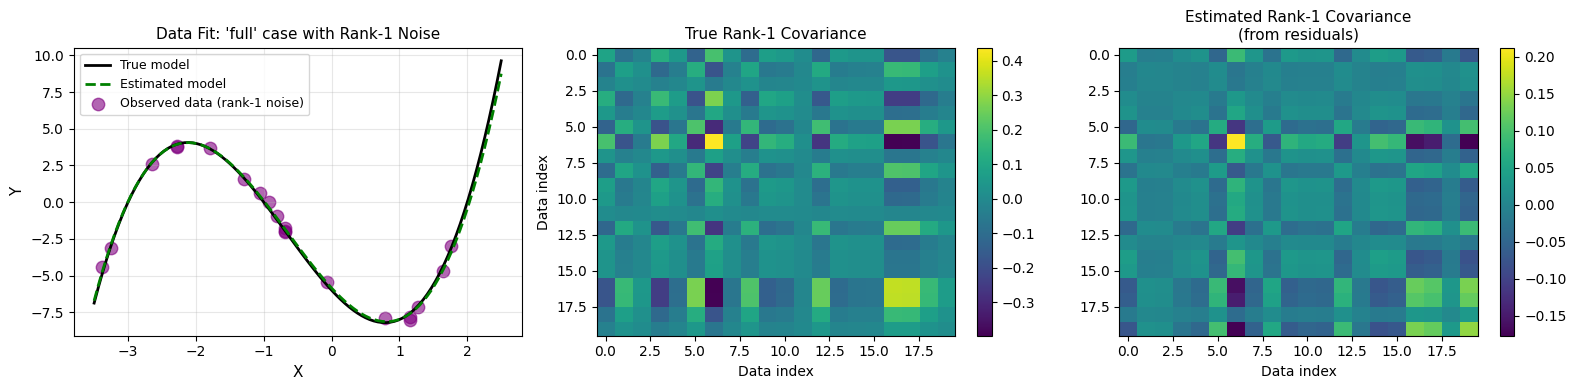


Summary: The 'full' case correctly recovers a rank-1 covariance structure
when the true noise is rank-1. The direction alignment shows how well the
estimated covariance captures the true noise correlation pattern.


In [100]:
# Visualize the rank-1 case results
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1: Data fit
_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)
axes[0].plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=2, label='True model')
axes[0].plot(_x_plot, _G_plot @ result_rl_full_rank1.model, 'g--', linewidth=2, label='Estimated model')
axes[0].scatter(x, y_observed_rank1, color='purple', s=80, alpha=0.6, label='Observed data (rank-1 noise)')
axes[0].set_xlabel('X', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title("Data Fit: 'full' case with Rank-1 Noise", fontsize=11)
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# Plot 2: True vs Estimated covariance matrices
im1 = axes[1].imshow(Cd_true_rank1, cmap='viridis', aspect='auto')
axes[1].set_title('True Rank-1 Covariance', fontsize=11)
axes[1].set_xlabel('Data index')
axes[1].set_ylabel('Data index')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(Cd_ml_rank1, cmap='viridis', aspect='auto')
axes[2].set_title('Estimated Rank-1 Covariance\n(from residuals)', fontsize=11)
axes[2].set_xlabel('Data index')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"\nSummary: The 'full' case correctly recovers a rank-1 covariance structure")
print(f"when the true noise is rank-1. The direction alignment shows how well the")
print(f"estimated covariance captures the true noise correlation pattern.")

In [104]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "pandas"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10+31.gd8a24f3.dirty
numpy 2.2.6
scipy 1.15.3
matplotlib 3.10.7
pandas 2.3.3
